# Intro

In [1]:
import os
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Drone_Recog/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

In [3]:
h, w = 224, 224
epochs = 500
seq = 25
vid_path = 'datasets/Actions'
OP_path = 'datasets/OpenPose'

class_names = os.listdir(vid_path)
num_class = len(class_names)

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Apr 25 16:43:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset

In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [ ]:
def get_frames(path):
    """
    Function extracts frames of video after it is resize and normalized
    in the form of a list.
    :param path: path of video
    :return: list of frames of every video
    """

    frame_list = []

    # set capture object and count frames
    vid_reader = cv2.VideoCapture(path)
    frame_count = int(vid_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_skip = max(int(frame_count / seq), 1)

    # extracting frames
    for i in range(seq):
        # skip a couple of frames (don't need everything)
        vid_reader.set(cv2.CAP_PROP_POS_FRAMES, i * frame_skip)
        success, frame = vid_reader.read()
        # if no more frames, finish
        if not success:
            break
        frame = crop_center_square(frame)
        frame = cv2.resize(frame, (w, h))
        frame = frame / 255
        frame_list.append(frame)
    vid_reader.release()  # release object

    return frame_list

In [ ]:
feat = []
lbl = []

for idx, class_name in enumerate(class_names):
    print(f'Extracting rgb from: {class_name}')  # show progress
    files = os.listdir(os.path.join(vid_path, class_name))
    for name in files:
        print(f'    {name}...')
        path = os.path.join(vid_path, class_name, name)
        frames = get_frames(path)
        if len(frames) == seq:
            feat.append(frames)
            lbl.append(idx)

Extracting rgb from: clapping
    S3_clapping_HD.mp4...
    S4_clapping_HD.mp4...
    S5_clapping_HD.mp4...
    S6_clapping_HD.mp4...
    S7_clapping_HD.mp4...
    S8_clapping_HD.mp4...
    S9_clapping_HD.mp4...
    S10_clapping_HD.mp4...
    S1_clapping_HD.mp4...
    S2_clapping_HD.mp4...
Extracting rgb from: kicking
    S1_kicking_toLeft_HD.mp4...
    S3_kicking_toRight_HD.mp4...
    S3_kicking_toLeft_HD.mp4...
    S4_kicking_toRight_HD.mp4...
    S4_kicking_toLeft_HD.mp4...
    S5_kicking_toRight_HD.mp4...
    S5_kicking_toLeft_HD.mp4...
    S6_kicking_toRight_HD.mp4...
    S6_kicking_toLeft_HD.mp4...
    S7_kicking_toLeft_HD.mp4...
    S7_kicking_toRight_HD.mp4...
    S8_kicking_toRight_HD.mp4...
    S8_kicking_toLeft_HD.mp4...
    S9_kicking_toRight_HD.mp4...
    S9_kicking_toLeft_HD.mp4...
    S10_kicking_toRight_HD.mp4...
    S10_kicking_toLeft_HD.mp4...
    S1_kicking_toRight_HD.mp4...
    S2_kicking_toRight_HD.mp4...
    S2_kicking_toLeft_HD.mp4...
Extracting rgb from: stabbin

In [ ]:
# converting to array
feat = np.asarray(feat)
lbl = np.array(lbl)

print(feat.shape)
print(lbl.shape)

(119, 25, 224, 224, 3)
(119,)


In [ ]:
# saving to numpy arrays
if not os.path.exists('datasets/image_array'):
    os.makedirs('datasets/image_array')
    print("Created new directory 'image_array' in datasets")
np.save(f'datasets/image_array/{h}x{w}_feat_{seq}', feat)
np.save(f'datasets/image_array/{h}x{w}_lbl_{seq}', lbl)

In [ ]:
OP_feat = []
OP_lbl = []

for idx, class_name in enumerate(class_names):
    print(f'Extracting openpose data from: {class_name}')  # show progress
    files = os.listdir(os.path.join(OP_path, class_name))
    for name in files:
        print(f'    {name}...')
        path = os.path.join(OP_path, class_name, name)
        frames = get_frames(path)
        if len(frames) == seq:
            OP_feat.append(frames)
            OP_lbl.append(idx)

Extracting openpose data from: clapping
    S9_clapping_HD.mp4...
    S2_clapping_HD.mp4...
    S10_clapping_HD.mp4...
    S1_clapping_HD.mp4...
    S6_clapping_HD.mp4...
    S7_clapping_HD.mp4...
    S4_clapping_HD.mp4...
    S3_clapping_HD.mp4...
    S5_clapping_HD.mp4...
    S8_clapping_HD.mp4...
Extracting openpose data from: kicking
    S9_kicking_toLeft_HD.mp4...
    S7_kicking_toLeft_HD.mp4...
    S3_kicking_toRight_HD.mp4...
    S5_kicking_toLeft_HD.mp4...
    S6_kicking_toRight_HD.mp4...
    S10_kicking_toLeft_HD.mp4...
    S6_kicking_toLeft_HD.mp4...
    S8_kicking_toLeft_HD.mp4...
    S8_kicking_toRight_HD.mp4...
    S2_kicking_toLeft_HD.mp4...
    S9_kicking_toRight_HD.mp4...
    S4_kicking_toRight_HD.mp4...
    S2_kicking_toRight_HD.mp4...
    S3_kicking_toLeft_HD.mp4...
    S4_kicking_toLeft_HD.mp4...
    S1_kicking_toRight_HD.mp4...
    S5_kicking_toRight_HD.mp4...
    S7_kicking_toRight_HD.mp4...
    S10_kicking_toRight_HD.mp4...
    S1_kicking_toLeft_HD.mp4...
Extracti

In [ ]:
# converting to array
OP_feat = np.asarray(OP_feat)
OP_lbl = np.array(OP_lbl)

print(OP_feat.shape)
print(OP_lbl.shape)

(119, 25, 224, 224, 3)
(119,)


In [ ]:
# saving to numpy arrays
if not os.path.exists('datasets/image_array'):
    os.makedirs('datasets/image_array')
    print("Created new directory 'image_array' in datasets")
np.save(f'datasets/image_array/{h}x{w}_OPfeat_{seq}', OP_feat)
np.save(f'datasets/image_array/{h}x{w}_OPlbl_{seq}', OP_lbl)

# Model

In [5]:
# RGB CNN
def build_rgb_cnn():
    In = Input(shape=(seq, h, w, 3), name = 'rgb-cnn input')
    x = Conv3D(32, (3, 3, 3), strides = (1, 2, 2), padding='same', activation='relu', name = 'conv3d_1')(In)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides = (1, 2, 2), name='pool_1')(x)

    x = Conv3D(64, (3, 3, 3), padding='same', activation='relu', name='conv3d_2')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides = (2, 2, 2), name='pool_2')(x)

    return Model(In, x, name = 'rgb_cnn_model')

In [6]:
# OP CNN
def build_op_cnn():
    In = Input(shape=(seq, h, w, 3), name = 'op-cnn input')
    x = Conv3D(32, (3, 3, 3), strides = (1, 2, 2), padding='same', activation='relu', name = 'conv3d_1')(In)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides = (1, 2, 2), name='pool_1')(x)

    x = Conv3D(64, (3, 3, 3), padding='same', activation='relu', name='conv3d_2')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides = (2, 2, 2), name='pool_2')(x)

    return Model(In, x, name = 'op_cnn_model')

In [7]:
# RGB-OP LRCN
def build_combined_cnn():
    In = Input(shape=(13, 28, 28, 128), name = 'combined-cnn input')
    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_3a')(In)
    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_3b')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides = (2, 2, 2), name='pool_3')(x)

    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_4a')(x)
    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu', name='conv3d_4b')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides = (2, 2, 2), name='pool_4')(x)

    x = Dropout(0.65, name = 'dropout')(x)
    return Model(In, x, name = 'CombinedCNN_Model')

In [8]:
# inputs for both models
RGB_input = Input(shape=(seq, h, w, 3), name = 'rgb_input')
OP_input = Input(shape=(seq, h, w, 3), name = 'op_input')

# build all models
rgb_model = build_rgb_cnn()
op_model = build_op_cnn()
combined_model = build_combined_cnn()

# passing input through both models
rgb_cnn = rgb_model(RGB_input)
op_cnn = op_model(OP_input)

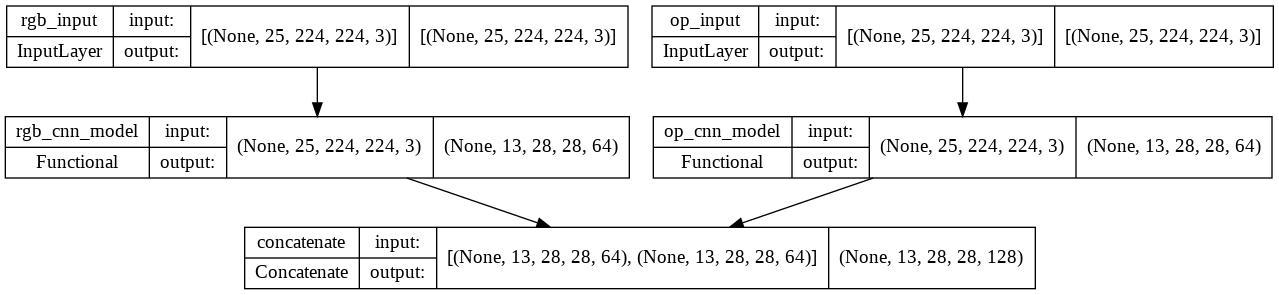

In [9]:
Combined_Model = Concatenate(axis=-1, name = 'concatenate')([rgb_cnn, op_cnn])

# half checkpoint
model = Model((RGB_input, OP_input), Combined_Model)
plot_model(model, show_shapes = True)

In [10]:
# combined model to next cnn model
combined_cnn = combined_model(Combined_Model)

# LSTM model
x = TimeDistributed(Flatten(), name = 'flatten')(combined_cnn)
x = Dropout(0.5, name = 'dropout')(x)
x = tf.keras.layers.LSTM(512, name = 'LSTM')(x)
LRCN_output = Dense(num_class, activation = 'softmax')(x)

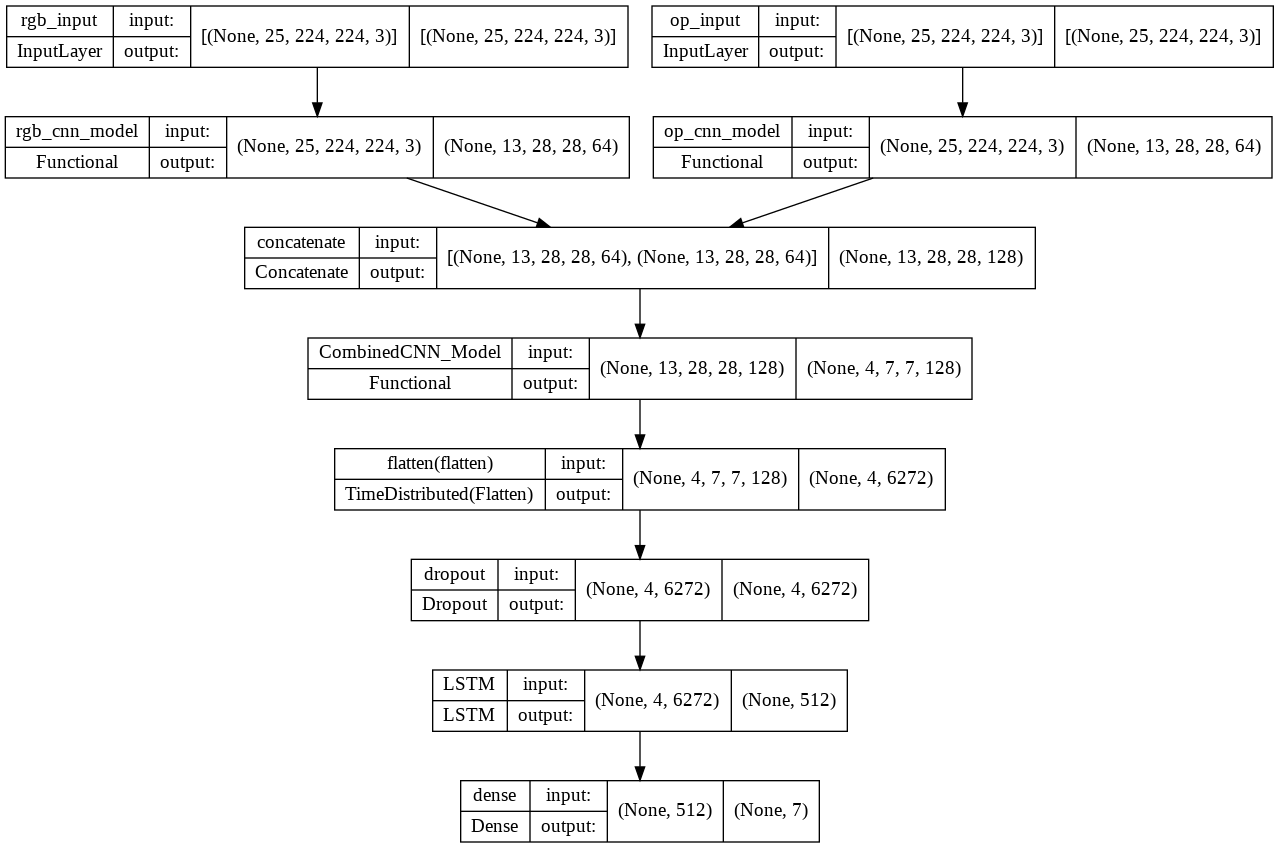

In [11]:
LRCN_model = Model((RGB_input, OP_input), LRCN_output)
plot_model(LRCN_model, show_shapes = True)

# Training

## Plotting

In [12]:
def plot_graph(training_history, metric1, metric2, plot_name):
    """
    Function to plot and show graph of accuracy and loss
    :param training_history: record of training and validation (acc/loss)
    :param metric1: first metric
    :param metric2: second metric
    :param plot_name: name of plot
    """

    # Get metric values using metric names as identifiers.
    metric_1 = training_history.history[metric1]
    metric_2 = training_history.history[metric2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_1))

    # Plotting
    plt.plot(epochs, metric_1, 'blue', label=metric1)
    plt.plot(epochs, metric_2, 'red', label=metric2)

    # Add title
    plt.title(str(plot_name))

    # Legends
    plt.legend()
    plt.show()

## Train Data

In [13]:
# load data
rgb_features = np.load(f'datasets/image_array/{h}x{w}_feat_{seq}.npy')
rgb_labels = np.load(f'datasets/image_array/{h}x{w}_lbl_{seq}.npy')
OP_features = np.load(f'datasets/image_array/{h}x{w}_OPfeat_{seq}.npy')
OP_labels = np.load(f'datasets/image_array/{h}x{w}_OPlbl_{seq}.npy')

print(rgb_features.shape)
print(OP_features.shape)
print(rgb_labels.shape)

(119, 25, 224, 224, 3)
(119, 25, 224, 224, 3)
(119,)


In [14]:
# compile model
LRCN_model.compile(loss = 'sparse_categorical_crossentropy', # measures model accuracy
              optimizer = optimizers.Adam(learning_rate = 0.000005),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [15]:
# split datasets - rgb
rgb_features, rgb_test, rgb_labels, lbl_test = train_test_split(
    rgb_features, rgb_labels, test_size=0.15, shuffle=True, random_state = 25)
rgb_features, rgb_val, rgb_labels, lbl_val = train_test_split(
    rgb_features, rgb_labels, test_size=0.3, shuffle=True, random_state = 125)

print(rgb_labels)
print(lbl_val)
print(lbl_test)

[3 4 6 1 0 3 0 3 4 3 6 3 4 2 1 2 4 0 4 2 1 2 4 5 4 1 4 4 5 3 6 1 4 1 1 6 6
 2 6 2 3 5 3 6 1 1 4 1 3 2 1 3 2 2 2 5 1 6 2 3 3 4 6 0 6 0 3 5 4 2]
[1 4 6 2 4 2 2 3 3 1 0 5 1 5 3 1 6 0 0 1 2 3 6 5 4 6 2 5 2 6 4]
[1 4 3 4 5 3 0 2 1 6 3 4 2 1 6 6 0 6]


In [16]:
# split datasets - OP
OP_features, OP_test, OP_labels, OPlbl_test = train_test_split(
    OP_features, OP_labels, test_size=0.15, shuffle=True, random_state = 25)
OP_features, OP_val, OP_labels, OPlbl_val = train_test_split(
    OP_features, OP_labels, test_size=0.3, shuffle=True, random_state = 125)

print(OP_labels)
print(OPlbl_val)
print(OPlbl_test)

[3 4 6 1 0 3 0 3 4 3 6 3 4 2 1 2 4 0 4 2 1 2 4 5 4 1 4 4 5 3 6 1 4 1 1 6 6
 2 6 2 3 5 3 6 1 1 4 1 3 2 1 3 2 2 2 5 1 6 2 3 3 4 6 0 6 0 3 5 4 2]
[1 4 6 2 4 2 2 3 3 1 0 5 1 5 3 1 6 0 0 1 2 3 6 5 4 6 2 5 2 6 4]
[1 4 3 4 5 3 0 2 1 6 3 4 2 1 6 6 0 6]


In [17]:
rgb_features = tf.stack(rgb_features)
rgb_labels = tf.stack(rgb_labels)
rgb_test = tf.stack(rgb_test)
lbl_test = tf.stack(lbl_test)

OP_features = tf.stack(OP_features)
OP_labels = tf.stack(OP_labels)
OP_test = tf.stack(OP_test)
OPlbl_test = tf.stack(OPlbl_test)

In [18]:
# combine validation data
X_val = np.concatenate((rgb_val, OP_val), axis=0)
Y_val = np.concatenate((lbl_val, OPlbl_val), axis=0)
print(X_val.shape)
print(Y_val.shape)

(62, 25, 224, 224, 3)
(62,)


In [19]:
# create instance of early stopping callback
early_stop_callback = EarlyStopping(monitor='val_loss', patience=15,
                                    mode='min', restore_best_weights=True)

In [20]:
# Run Training
LRCN_history = LRCN_model.fit([rgb_features, OP_features], 
                              rgb_labels,
                              validation_data=(X_val, Y_val),
                              epochs=epochs,
                              batch_size = 2,
                              callbacks=[early_stop_callback])

Epoch 1/500
35/35 [==============================] - ETA: 0s - loss: 1.9426 - categorical_accuracy: 0.0286

ValueError: ignored